# 🧱 DreamScape AI — Setup Notebook
### Deliverable 2 · Dataset Verification and Environment Check

**Purpose:**  
- Verify that the DreamBank Annotated dataset loads correctly from Hugging Face.  
- Perform a minimal exploratory check (rows, columns, missing data).  
- Plot 1–2 simple statistics to confirm visualization setup.  
- Save a small processed JSON sample to `/data/processed/`.

### 1. Imports & Folder Setup

In [1]:
import os, warnings, json
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

warnings.filterwarnings("ignore")

# Define paths
BASE = Path("..").resolve() if Path(".").name == "notebooks" else Path(".").resolve()
DATA_RAW = BASE / "data" / "raw"
DATA_PROC = BASE / "data" / "processed"
RESULTS = BASE / "results"

for p in (DATA_RAW, DATA_PROC, RESULTS):
    p.mkdir(parents=True, exist_ok=True)

print(f"Working directory: {BASE}")
print(f"Raw data: {DATA_RAW}")
print(f"Processed data: {DATA_PROC}")

Working directory: /Users/saturnine/Dreamscape/notebooks
Raw data: /Users/saturnine/Dreamscape/notebooks/data/raw
Processed data: /Users/saturnine/Dreamscape/notebooks/data/processed


### 2. Load Dataset from Hugging Face

In [2]:
from datasets import load_dataset

ds = load_dataset("gustavecortal/DreamBank-annotated")
df = ds["train"].to_pandas()

print(f"DreamBank loaded — {len(df):,} entries, {df.shape[1]} columns")
df.head(3)

DreamBank loaded — 27,952 entries, 10 columns


,id,name,number,time,date,gender,age,report,character,emotion
0,alta,Alta: a detailed dreamer,1,1985-1997,1957,F,A,"The one at the Meads's house, where it's bigge...","1MSA, 1FSA, 1FKA, 2ISA",None
1,alta,Alta: a detailed dreamer,2,1985-1997,8/11/67,F,A,I'm at a family reunion in a large fine house ...,"2MSA, 2JSA",None
2,alta,Alta: a detailed dreamer,3,1985-1997,8/1/85,F,A,I watch a plane fly past and shortly realize i...,"2ISA, 1FSA, 2ISA, 1MKA, 1MKA",None


### 3. Describe Columns
**Dataset columns overview**

| Column | Description |
|--------|--------------|
| `id` | Dreamer identifier |
| `name` | Dreamer name/source |
| `number` | Dream index per dreamer |
| `time`, `date` | Period of dream |
| `gender`, `age` | Demographics |
| `report` | Full dream text |
| `character`, `emotion` | HVdC-coded tags |

### 4. Minimal Cleaning Preview

In [3]:
# Drop empty or too-short texts
df = df.dropna(subset=["report"])
df["report"] = df["report"].astype(str).str.strip()
df = df[df["report"].str.len() > 50].reset_index(drop=True)

print(f"After cleaning: {len(df)} dreams remain.")
df.sample(3)

After cleaning: 27553 dreams remain.


,id,name,number,time,date,gender,age,report,character,emotion
24249,pegasus,Pegasus: a factory worker,1007,1949-1964,12/10/63,M,A,I was intimating my wife and she said we are g...,"1FKA, 1FKA, 1FKA",AP 1FKA
26716,ucsc_women,"UCSC women, 1996",65,1996,21/female,F,Y,"I was in a dark room, in the room I was sleepi...","2JKA, 1MKA",CO D
17709,kenneth,Kenneth,1211,1996-1998,10/14/1997,M,Y,<i>Hunting Repercussions</i> <br/><br/> I step...,"2JKA, 1FKA, 1FKA, 1MKA, 2JSA, 1MKA, 2JSA",None


### 4. Summary Statistics

Average length: 174.4117156026567


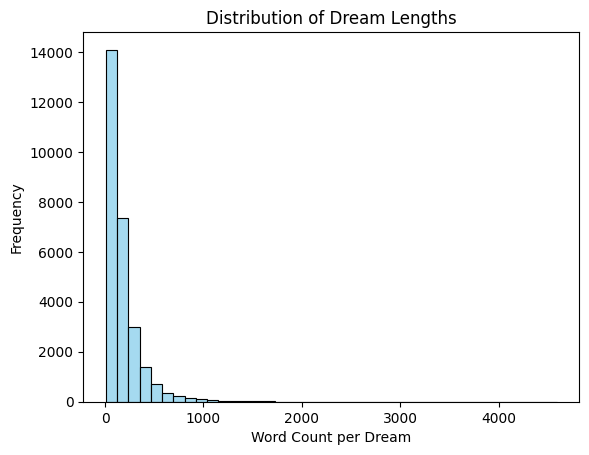

In [4]:
df["text_len"] = df["report"].str.len()
df["word_count"] = df["report"].str.split().apply(len)

print("Average length:", df["word_count"].mean())

sns.histplot(df["word_count"], bins=40, color="skyblue")
plt.xlabel("Word Count per Dream")
plt.ylabel("Frequency")
plt.title("Distribution of Dream Lengths")
plt.savefig(RESULTS / "dream_length_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

In [5]:
df = df.rename(columns={"report": "text"})

### 5. Save a Sample JSON

In [6]:
sample = df.sample(1000, random_state=42)
out_json = DATA_PROC / "dreambank_clean.json"
sample.to_json(out_json, orient="records", force_ascii=False)
print(f"Saved {len(sample)} cleaned dream entries → {out_json}")

Saved 1000 cleaned dream entries → /Users/saturnine/Dreamscape/notebooks/data/processed/dreambank_clean.json


### 6. Verification Summary

### Setup Verification Summary
- Dataset successfully loaded from Hugging Face (`gustavecortal/DreamBank-annotated`)
- Columns verified and non-empty
- Basic histogram generated (`results/dream_length_distribution.png`)
- Cleaned sample saved → `data/processed/dreambank_clean.json`

**Next Notebook:**  
→ `exploratory_data_analysis.ipynb` (Deep EDA on emotions, HVdC tags, and dream themes)